#**3. Plot transformed inpute over training data**

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


#**Get helper functions and utilities**

In [2]:
print("[INFO] downloading helper functions from GitHub.")
!git clone https://github.com/AbigailUchennaNkama/model-drift-simulation
!mv model-drift-simulation/drift_modules/load_model.py .
!mv model-drift-simulation/drift_modules/get_all_data.py .
!mv model-drift-simulation/model .
!rm -rf model-drift-simulation

[INFO] downloading helper functions from GitHub.
Cloning into 'model-drift-simulation'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 242 (delta 47), reused 73 (delta 46), pack-reused 167
Receiving objects: 100% (242/242), 167.43 MiB | 17.13 MiB/s, done.
Resolving deltas: 100% (142/142), done.
Updating files: 100% (29/29), done.


In [3]:
!python get_all_data.py

Creating cifar10 dataset...
100% 135107811/135107811 [00:02<00:00, 46723243.46it/s]
Creating cifar9 dataset...
Images organized into subfolders based on class names.


#**load pretrained model**

In [4]:
from load_model import load_custom_pretrained_model
loaded_model_c9 = load_custom_pretrained_model(model_path='./model/cifar9_model_2.pth', num_classes=9)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 80.5MB/s]


In [14]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
from torchvision import models

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a function to get embeddings from a dataset using a given model
def get_embeddings(model, data_path):
    model = model.to(device)
    model.eval()

    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    testset = torchvision.datasets.ImageFolder(root=data_path, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

    # Extract embeddings and labels
    embeddings, labels = [], []

    with torch.no_grad():
        for images, lbls in testloader:
            images, lbls = images.to(device), lbls.to(device)
            emb = model(images).squeeze(-1).squeeze(-1)
            embeddings.append(emb)
            labels.append(lbls)

    embeddings = torch.cat(embeddings).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()

    return embeddings, labels

# Example usage
# if __name__ == "__main__":
#     model = models.resnet18(pretrained=True)
#     data_path = '/path/to/your/image/dataset'  # Replace with the actual path to the image dataset
#     embeddings, labels = get_embeddings(model, data_path)


# **Get embeddings**

In [15]:
train_data_path = './data/cifar9/train'
test_data_path = './data/cifar10/test'

# Define and load a pre-trained model (e.g., ResNet-18)
model = loaded_model_c9

# Get embeddings and labels for training and test data
train_embeddings, train_labels = get_embeddings(model, train_data_path)
test_embeddings, test_labels = get_embeddings(model, test_data_path)

#**t-sne**

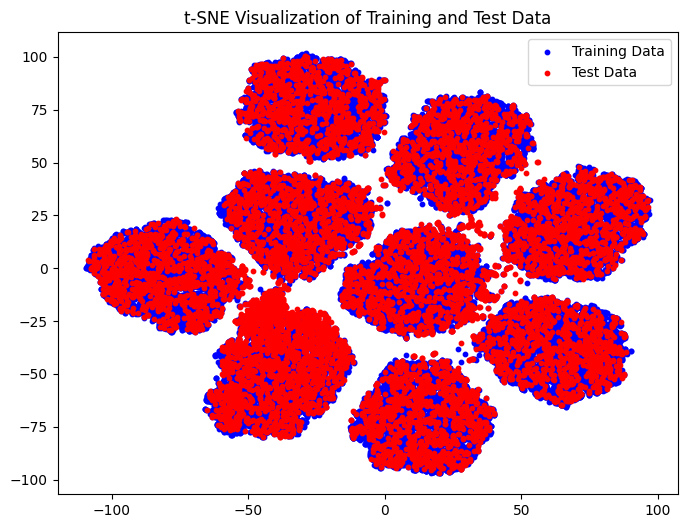

In [16]:
# Apply dimensionality reduction (t-SNE for this example)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
combined_embeddings = np.vstack([train_embeddings, test_embeddings])
combined_labels = np.concatenate([train_labels, test_labels])
tsne_embeddings = tsne.fit_transform(combined_embeddings)

# Separate training and test data in the t-SNE embeddings
train_tsne_embeddings = tsne_embeddings[:len(train_embeddings)]
test_tsne_embeddings = tsne_embeddings[len(train_embeddings):]

# Visualize both training and test embeddings with different colors
plt.figure(figsize=(8, 6))
plt.scatter(train_tsne_embeddings[:, 0], train_tsne_embeddings[:, 1], c='brown', label='Training Data', s=10)
plt.scatter(test_tsne_embeddings[:, 0], test_tsne_embeddings[:, 1], c='r', label='Test Data', s=10)
plt.title('t-SNE Visualization of Training and Test Data')
plt.legend()
plt.show()


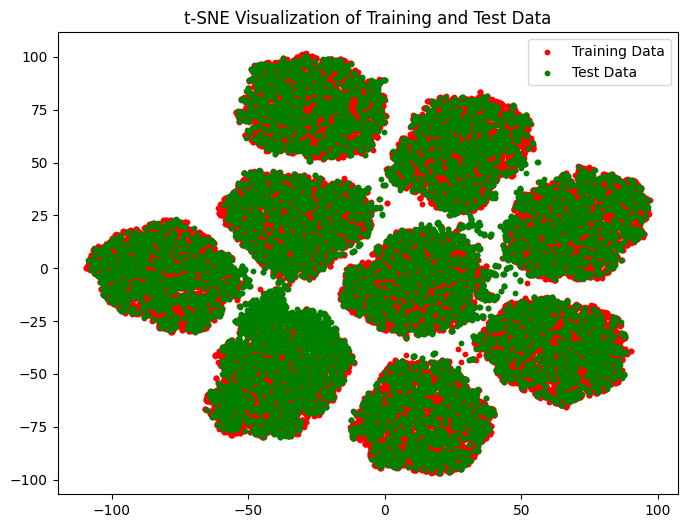

In [30]:
# Visualize both training and test embeddings with different colors
plt.figure(figsize=(8, 6))
plt.scatter(train_tsne_embeddings[:, 0], train_tsne_embeddings[:, 1], c='r', label='Training Data', s=10)
plt.scatter(test_tsne_embeddings[:, 0], test_tsne_embeddings[:, 1], c='g', label='Test Data', s=10)
plt.title('t-SNE Visualization of Training and Test Data')
plt.legend()
plt.show()

#**umap**

In [ ]:
pip install umap-learn

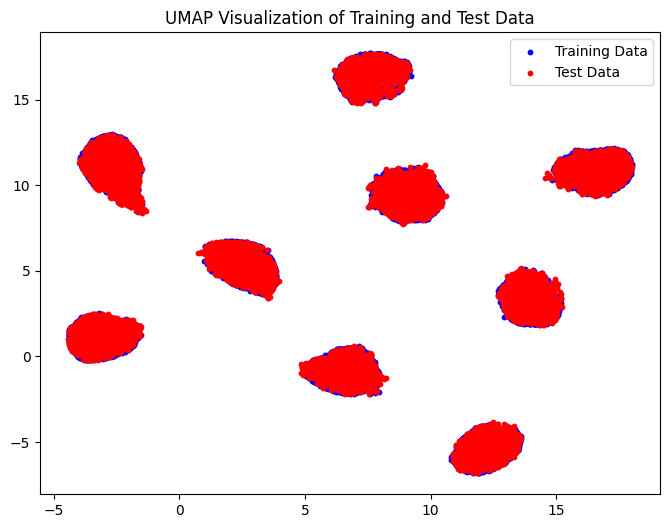

In [24]:
import umap
import numpy as np
import matplotlib.pyplot as plt


# Use UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='correlation')
umap_embeddings = umap_model.fit_transform(combined_embeddings)

# Separate training and test data in the UMAP embeddings
train_umap_embeddings = umap_embeddings[:len(train_embeddings)]
test_umap_embeddings = umap_embeddings[len(train_embeddings):]

# Visualize both training and test embeddings with different colors
plt.figure(figsize=(8, 6))
plt.scatter(train_umap_embeddings[:, 0], train_umap_embeddings[:, 1], c='b', label='Training Data', s=10)
plt.scatter(test_umap_embeddings[:, 0], test_umap_embeddings[:, 1], c='r', label='Test Data', s=10)
plt.title('UMAP Visualization of Training and Test Data')
plt.legend()
plt.show()


#**Save and load embeddings and labels**

In [22]:
from sklearn.manifold import TSNE
from joblib import load
import torch
# Save embeddings and labels
torch.save(combined_embeddings, 'combined_embeddings.pt')
torch.save(combined_labels, 'combined_labels.pt')

In [23]:
#Load embeddings and labels
combined_labels = torch.load('./combined_labels.pt')
combined_embeddings = torch.load('./combined_embeddings.pt')